Import necessary libraries for data analysis, visualization, and machine learning

In [214]:
import pandas as pd                  # For data manipulation and analysis
import numpy as np                   # For numerical operations
import matplotlib.pyplot as plt     # For plotting and visualization
import seaborn as sns               # For enhanced data visualization
from sklearn.model_selection import train_test_split   # To split data into training and testing sets
from sklearn.linear_model import LogisticRegression     # Logistic Regression model
from sklearn.metrics import confusion_matrix            # To compute confusion matrix
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix  # For evaluation metrics

Data Cleaning & Preparation

In [217]:
# Load the dataset from a CSV file into a pandas DataFrame
df = pd.read_csv("ecommerce_returns_synthetic_data.csv")

In [219]:
# Convert 'Order_Date' and 'Return_Date' columns to datetime format for easier date manipulation
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Return_Date'] = pd.to_datetime(df['Return_Date'])

In [221]:
# Create a binary target variable 'Returned': 1 if the item was returned, 0 otherwise
df['Returned'] = df['Return_Status'].apply(lambda x: 1 if x == 'Returned' else 0)

In [223]:
# Handle missing values by filling NaNs in 'Return_Reason' with 'No Return'
# and missing 'Days_to_Return' values with 0
df['Return_Reason'] = df['Return_Reason'].fillna('No Return')
df['Days_to_Return'] = df['Days_to_Return'].fillna(0)

In [225]:
# Drop columns that are not needed for modeling to simplify the dataset
df = df.drop(columns=['Order_ID', 'Product_ID', 'User_ID', 'Order_Date', 'Return_Date', 'Return_Status'])

Exploratory Data Analysis

In [228]:
# Set seaborn style to 'whitegrid' for cleaner and more readable plots
sns.set(style="whitegrid")

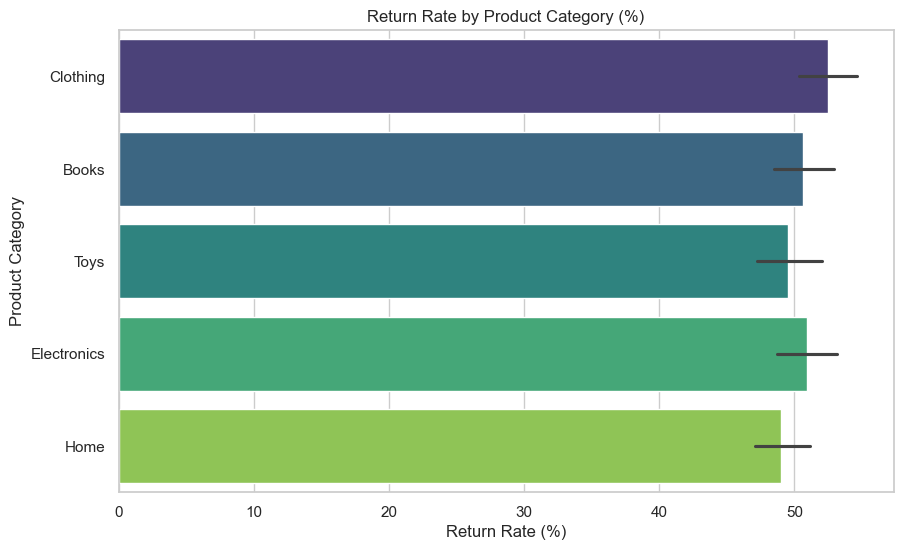

In [230]:
# Plot the return rate (%) by Product Category using a horizontal bar plot
# The estimator calculates the percentage of returned items per category
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Returned', 
    y='Product_Category', 
    hue='Product_Category',  
    data=df, 
    estimator=lambda x: sum(x)/len(x)*100,  # Calculate return rate as percentage
    palette='viridis',
    dodge=False,             # Do not separate bars by hue since hue = y variable
    legend=False             # Hide legend as colors correspond directly to categories
)
plt.title("Return Rate by Product Category (%)")
plt.xlabel("Return Rate (%)")
plt.ylabel("Product Category")
plt.show()

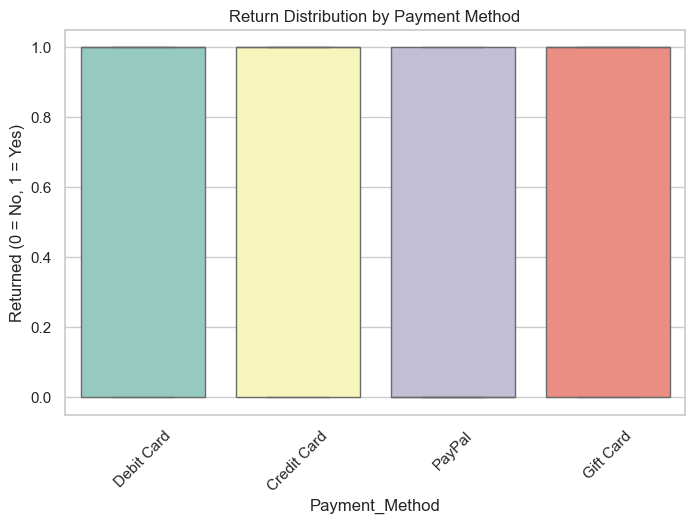

In [232]:
# Visualize the distribution of returns (0 or 1) across different Payment Methods using a boxplot
# The boxplot shows the spread of return values for each payment method
plt.figure(figsize=(8, 5))
sns.boxplot(
    x='Payment_Method', 
    y='Returned', 
    data=df, 
    hue='Payment_Method',    
    palette='Set3',
    dodge=False              # Do not separate boxes by hue since hue = x variable
)
plt.legend([],[], frameon=False)  # Remove legend to reduce clutter
plt.title("Return Distribution by Payment Method")
plt.ylabel("Returned (0 = No, 1 = Yes)")
plt.xticks(rotation=45)            # Rotate x-axis labels for better readability
plt.show()

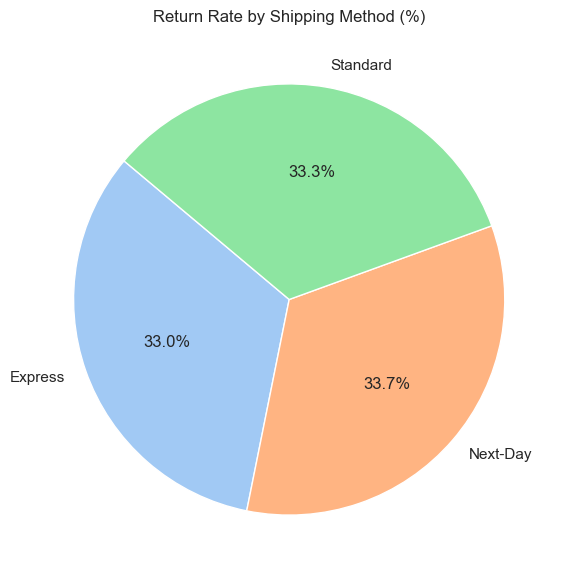

In [234]:
# Calculate return rate (%) by Shipping Method and visualize it as a pie chart
return_rates = df.groupby('Shipping_Method')['Returned'].mean() * 100

plt.figure(figsize=(7, 7))
return_rates.plot.pie(
    autopct='%1.1f%%',            # Display percentage on each pie slice
    colors=sns.color_palette('pastel'),  # Use pastel color palette for slices
    startangle=140                # Start angle to rotate the pie chart for better aesthetics
)
plt.title("Return Rate by Shipping Method (%)")
plt.ylabel("")                   # Remove y-axis label for cleaner look
plt.show()

Logistic Regression Model

In [237]:
# Perform one-hot encoding on categorical variables, dropping the first category to avoid multicollinearity
df_encoded = pd.get_dummies(df, drop_first=True)

In [239]:
# Separate the features (X) from the target variable (y)
X = df_encoded.drop(columns='Returned')  # Features for modeling
y = df_encoded['Returned']                # Target variable indicating return status

In [241]:
# Split the dataset into training and testing sets (80% train, 20% test) with a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [243]:
# Initialize and train a Logistic Regression model with increased max iterations for convergence
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [245]:
# Make predictions on the test set
# y_pred: predicted class labels
# y_proba: predicted probabilities for the positive class (Returned = 1)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [247]:
# Evaluate model performance using classification report (precision, recall, f1-score) and ROC AUC score
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1009
           1       1.00      1.00      1.00       991

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC Score: 1.0


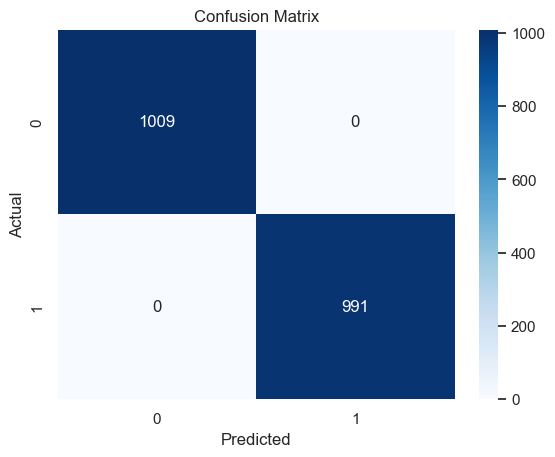

In [249]:
# Plot a heatmap of the confusion matrix to visualize true vs predicted classifications
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Export High-Risk Products

In [252]:
# Create a copy of the test features and append predicted return probabilities
# Add a new column 'Predicted_Return' based on a threshold of 0.7 for classification
X_test_copy = X_test.copy()
X_test_copy['Return_Probability'] = y_proba
X_test_copy['Predicted_Return'] = (X_test_copy['Return_Probability'] > 0.7).astype(int)

In [254]:
# Filter products with a high return probability (> 0.7) and export them to a CSV file for further analysis
high_risk = X_test_copy[X_test_copy['Return_Probability'] > 0.7]
high_risk.to_csv("high_risk_products.csv", index=False)